In [2]:
!pip install xgboost fairlearn aif360 scikit-learn pandas numpy matplotlib seaborn spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 907.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 39.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    selection_rate
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset


pip install 'aif360[inFairness]'


In [5]:
pip install 'aif360[inFairness]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.5 MB/s eta 0:00:00


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mdtalhask/ai-powered-resume-screening-dataset-2025")

print("Path to dataset files:", path)

100%|██████████| 22.8k/22.8k [00:00<00:00, 22.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mdtalhask/ai-powered-resume-screening-dataset-2025/versions/1


In [7]:
!pip -q install kagglehub xgboost fairlearn aif360 scikit-learn pandas numpy matplotlib


In [8]:
import kagglehub

path = kagglehub.dataset_download("mdtalhask/ai-powered-resume-screening-dataset-2025")
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'ai-powered-resume-screening-dataset-2025' dataset.
Path to dataset files: /kaggle/input/ai-powered-resume-screening-dataset-2025


In [9]:
import os
import glob
import pandas as pd

csv_files = glob.glob(os.path.join(path, "*.csv"))
print("CSV files found:", csv_files)

df = pd.read_csv(csv_files[0])  # if multiple, pick correct index
print(df.shape)
df.head()


CSV files found: ['/kaggle/input/ai-powered-resume-screening-dataset-2025/AI_Resume_Screening.csv']
(1000, 11)


,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100)
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,NaN,AI Researcher,Hire,104895,8,100
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70
3,4,Elizabeth Carney,"Python, Pytorch, TensorFlow",7,B.Tech,AWS Certified,AI Researcher,Hire,46848,0,95
4,5,Julie Hill,"SQL, React, Java",4,PhD,NaN,Software Engineer,Hire,87441,9,100


In [10]:
import numpy as np
import re

df = df.copy()

# ---- Standardize column names (safe handling) ----
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
print("Columns:", df.columns.tolist())

# ---- Map likely column names safely ----
# Adjust if your dataset uses slightly different names
target_col = "recruiter_decision"  # expected Hire/Reject
skills_col = "skills"
edu_col = "education"
exp_col = "experience_(years)" if "experience_(years)" in df.columns else "experience_years"
cert_col = "certifications"
proj_col = "projects_count"
ai_score_col = "ai_score_(0-100)" if "ai_score_(0-100)" in df.columns else "ai_score_0-100"

# ---- Clean / normalize target label into 0/1 ----
df[target_col] = df[target_col].astype(str).str.strip().str.lower()
df["y"] = df[target_col].map({"hire": 1, "reject": 0})

# Drop rows with missing labels
df = df.dropna(subset=["y"]).copy()
df["y"] = df["y"].astype(int)

# ---- Feature: skills_count ----
def count_skills(s):
    if pd.isna(s):
        return 0
    # split on comma/pipe/semicolon
    parts = re.split(r"[,;|/]+", str(s))
    parts = [p.strip() for p in parts if p.strip()]
    return len(parts)

df["skills_count"] = df[skills_col].apply(count_skills) if skills_col in df.columns else 0

# ---- Feature: education_level (ordinal encoding) ----
# tweak mapping based on your dataset values
edu_map = {
    "high school": 1,
    "bachelor": 2,
    "bachelors": 2,
    "b.tech": 2,
    "btech": 2,
    "master": 3,
    "masters": 3,
    "m.tech": 3,
    "phd": 4,
    "doctorate": 4
}
def encode_edu(x):
    if pd.isna(x):
        return 0
    t = str(x).strip().lower()
    for k, v in edu_map.items():
        if k in t:
            return v
    return 0

df["education_level"] = df[edu_col].apply(encode_edu) if edu_col in df.columns else 0

# ---- Feature: certification_count ----
def count_certs(s):
    if pd.isna(s):
        return 0
    parts = re.split(r"[,;|/]+", str(s))
    parts = [p.strip() for p in parts if p.strip()]
    return len(parts)

df["certification_count"] = df[cert_col].apply(count_certs) if cert_col in df.columns else 0

# ---- Numerical columns (safe) ----
def safe_numeric(colname):
    if colname in df.columns:
        return pd.to_numeric(df[colname], errors="coerce").fillna(0)
    return pd.Series(np.zeros(len(df)))

df["experience_years"] = safe_numeric(exp_col)
df["projects_count"] = safe_numeric(proj_col)
df["ai_score"] = safe_numeric(ai_score_col)

df[["y","skills_count","education_level","certification_count","experience_years","projects_count","ai_score"]].head()


Columns: ['resume_id', 'name', 'skills', 'experience_(years)', 'education', 'certifications', 'job_role', 'recruiter_decision', 'salary_expectation_($)', 'projects_count', 'ai_score_(0-100)']


,y,skills_count,education_level,certification_count,experience_years,projects_count,ai_score
0,1,3,0,0,10,8,100
1,1,4,0,1,10,1,100
2,1,3,0,1,1,7,70
3,1,3,2,1,7,0,95
4,1,3,4,0,4,9,100


In [11]:
rng = np.random.default_rng(42)

# Example: create a balanced gender attribute (0/1) for fairness experiments
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)  # shuffle
df["gender"] = np.array([0,1] * (len(df)//2) + ([0] if len(df)%2 else []))

# Example: create 8 intersectional groups: White/Black/Asian/Hispanic × M/F
groups = ["White_M","White_F","Black_M","Black_F","Asian_M","Asian_F","Hispanic_M","Hispanic_F"]
df["race_gender"] = [groups[i % len(groups)] for i in range(len(df))]

print(df["gender"].value_counts())
print(df["race_gender"].value_counts().head())


gender
0    500
1    500
Name: count, dtype: int64
race_gender
White_M    125
White_F    125
Black_M    125
Black_F    125
Asian_M    125
Name: count, dtype: int64


In [12]:
from sklearn.model_selection import train_test_split

FEATURES = ["skills_count","education_level","certification_count","experience_years","projects_count","ai_score"]
X = df[FEATURES].copy()
y = df["y"].copy()

A = df["gender"]  # protected attribute (0/1)
# You can also use A = df["race_gender"] for intersectional analysis

X_train, X_temp, y_train, y_temp, A_train, A_temp = train_test_split(
    X, y, A, test_size=0.30, random_state=42, stratify=A
)

X_val, X_test, y_val, y_test, A_val, A_test = train_test_split(
    X_temp, y_temp, A_temp, test_size=0.50, random_state=42, stratify=A_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (700, 6) Val: (150, 6) Test: (150, 6)


In [13]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from fairlearn.metrics import demographic_parity_difference, equal_opportunity_difference

def impact_ratio(y_pred, A):
    # selection rate per group
    groups = pd.Series(A).unique()
    rates = []
    for g in groups:
        idx = (A == g)
        if idx.sum() == 0:
            continue
        rates.append(np.mean(y_pred[idx] == 1))
    if len(rates) < 2:
        return np.nan
    return (min(rates) / max(rates)) if max(rates) > 0 else np.nan

def evaluate_binary(model_name, y_true, y_pred, y_score, A):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_score) if len(np.unique(y_true)) == 2 else np.nan,
        "Impact_Ratio": impact_ratio(y_pred, A),
        "DP_Diff": demographic_parity_difference(y_true, y_pred, sensitive_features=A),
        "EO_Diff": equal_opportunity_difference(y_true, y_pred, sensitive_features=A),
    }


In [14]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from fairlearn.metrics import demographic_parity_difference, equal_opportunity_difference

def impact_ratio(y_pred, A):
    # selection rate per group
    groups = pd.Series(A).unique()
    rates = []
    for g in groups:
        idx = (A == g)
        if idx.sum() == 0:
            continue
        rates.append(np.mean(y_pred[idx] == 1))
    if len(rates) < 2:
        return np.nan
    return (min(rates) / max(rates)) if max(rates) > 0 else np.nan

def evaluate_binary(model_name, y_true, y_pred, y_score, A):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_score) if len(np.unique(y_true)) == 2 else np.nan,
        "Impact_Ratio": impact_ratio(y_pred, A),
        "DP_Diff": demographic_parity_difference(y_true, y_pred, sensitive_features=A),
        "EO_Diff": equal_opportunity_difference(y_true, y_pred, sensitive_features=A),
    }


In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "max_depth": [4,6,8],
    "learning_rate": [0.01, 0.1, 0.3],
    "n_estimators": [100,200,300],
    "subsample": [0.8]
}

grid = GridSearchCV(base, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid.fit(X_train, y_train)

best_params = grid.best_params_
print("Best params:", best_params)

baseline_model = XGBClassifier(**best_params, objective="binary:logistic", eval_metric="logloss", random_state=42, n_jobs=-1)
baseline_model.fit(X_train, y_train)

y_score_base = baseline_model.predict_proba(X_test)[:,1]
y_pred_base = (y_score_base >= 0.5).astype(int)

res_base = evaluate_binary("Baseline_XGB", y_test, y_pred_base, y_score_base, A_test)
res_base


Best params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}


{'Model': 'Baseline_XGB',
 'Accuracy': 1.0,
 'F1': 1.0,
 'ROC_AUC': np.float64(1.0),
 'Impact_Ratio': np.float64(0.890625),
 'DP_Diff': np.float64(0.09333333333333338),
 'EO_Diff': np.float64(0.0)}

In [16]:
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing

# Build AIF360 dataset from train split
train_df = X_train.copy()
train_df["y"] = y_train.values
train_df["gender"] = A_train.values

aif_train = BinaryLabelDataset(
    df=train_df,
    label_names=["y"],
    protected_attribute_names=["gender"]
)

rw = Reweighing(
    unprivileged_groups=[{"gender": 0}],
    privileged_groups=[{"gender": 1}]
)

aif_train_rw = rw.fit_transform(aif_train)
w_train = aif_train_rw.instance_weights

rw_model = XGBClassifier(**best_params, objective="binary:logistic", eval_metric="logloss", random_state=42, n_jobs=-1)
rw_model.fit(X_train, y_train, sample_weight=w_train)

y_score_rw = rw_model.predict_proba(X_test)[:,1]
y_pred_rw = (y_score_rw >= 0.5).astype(int)

res_rw = evaluate_binary("Pre_Reweighing_AIF360", y_test, y_pred_rw, y_score_rw, A_test)
res_rw


{'Model': 'Pre_Reweighing_AIF360',
 'Accuracy': 1.0,
 'F1': 1.0,
 'ROC_AUC': np.float64(1.0),
 'Impact_Ratio': np.float64(0.890625),
 'DP_Diff': np.float64(0.09333333333333338),
 'EO_Diff': np.float64(0.0)}

In [17]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

eg = ExponentiatedGradient(
    estimator=XGBClassifier(**best_params, objective="binary:logistic", eval_metric="logloss", random_state=42, n_jobs=-1),
    constraints=DemographicParity(),
    eps=0.02  # smaller = stricter fairness; tune if needed
)

eg.fit(X_train, y_train, sensitive_features=A_train)
y_pred_eg = eg.predict(X_test)

# score is not always available for EG; approximate by predicted labels
y_score_eg = y_pred_eg.astype(float)

res_eg = evaluate_binary("In_ExponentiatedGradient_DP", y_test, y_pred_eg, y_score_eg, A_test)
res_eg


{'Model': 'In_ExponentiatedGradient_DP',
 'Accuracy': 1.0,
 'F1': 1.0,
 'ROC_AUC': np.float64(1.0),
 'Impact_Ratio': np.float64(0.890625),
 'DP_Diff': np.float64(0.09333333333333338),
 'EO_Diff': np.float64(0.0)}

In [18]:
eps_values = [0.01, 0.02, 0.05]
eg_results = []

for eps in eps_values:
    eg = ExponentiatedGradient(
        estimator=XGBClassifier(**best_params, objective="binary:logistic", eval_metric="logloss", random_state=42, n_jobs=-1),
        constraints=DemographicParity(),
        eps=eps
    )
    eg.fit(X_train, y_train, sensitive_features=A_train)
    y_pred = eg.predict(X_test)
    eg_results.append(evaluate_binary(f"EG_DP_eps={eps}", y_test, y_pred, y_pred.astype(float), A_test))

pd.DataFrame(eg_results)


,Model,Accuracy,F1,ROC_AUC,Impact_Ratio,DP_Diff,EO_Diff
0,EG_DP_eps=0.01,1.0,1.0,1.0,0.890625,0.093333,0.0
1,EG_DP_eps=0.02,1.0,1.0,1.0,0.890625,0.093333,0.0
2,EG_DP_eps=0.05,1.0,1.0,1.0,0.890625,0.093333,0.0


In [19]:
from fairlearn.postprocessing import ThresholdOptimizer

thresh = ThresholdOptimizer(
    estimator=baseline_model,
    constraints="demographic_parity",
    predict_method="predict_proba"
)

thresh.fit(X_train, y_train, sensitive_features=A_train)
y_pred_th = thresh.predict(X_test, sensitive_features=A_test)

# Need scores for AUC: use baseline probability
y_score_th = y_score_base.copy()

res_th = evaluate_binary("Post_ThresholdOptimizer_DP", y_test, y_pred_th, y_score_th, A_test)
res_th


/usr/local/lib/python3.12/dist-packages/fairlearn/postprocessing/_interpolated_thresholder.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.24637681e-04 7.24637681e-04 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.24637681e-04 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 7.24637681e-04 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.24637681e-04 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.24637681e-04 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 7.24637681e-04
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.2463768

{'Model': 'Post_ThresholdOptimizer_DP',
 'Accuracy': 0.9933333333333333,
 'F1': 0.995850622406639,
 'ROC_AUC': np.float64(1.0),
 'Impact_Ratio': np.float64(0.875),
 'DP_Diff': np.float64(0.10666666666666669),
 'EO_Diff': np.float64(0.01754385964912286)}

In [20]:
results_df = pd.DataFrame([res_base, res_rw, res_eg, res_th])
results_df


,Model,Accuracy,F1,ROC_AUC,Impact_Ratio,DP_Diff,EO_Diff
0,Baseline_XGB,1.000000,1.000000,1.0,0.890625,0.093333,0.000000
1,Pre_Reweighing_AIF360,1.000000,1.000000,1.0,0.890625,0.093333,0.000000
2,In_ExponentiatedGradient_DP,1.000000,1.000000,1.0,0.890625,0.093333,0.000000
3,Post_ThresholdOptimizer_DP,0.993333,0.995851,1.0,0.875000,0.106667,0.017544


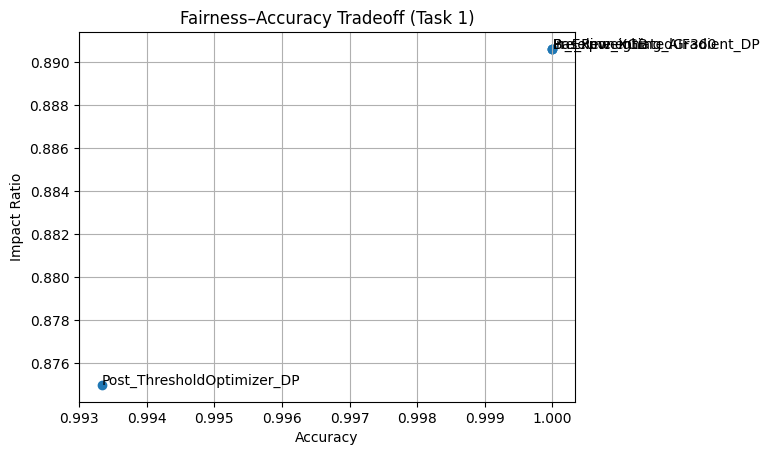

In [21]:
plt.figure()
plt.scatter(results_df["Accuracy"], results_df["Impact_Ratio"])
for _, r in results_df.iterrows():
    plt.annotate(r["Model"], (r["Accuracy"], r["Impact_Ratio"]))
plt.xlabel("Accuracy")
plt.ylabel("Impact Ratio")
plt.title("Fairness–Accuracy Tradeoff (Task 1)")
plt.grid(True)
plt.show()


In [22]:
from statsmodels.stats.contingency_tables import mcnemar

def mcnemar_test(y_true, pred_a, pred_b):
    a_correct = (pred_a == y_true)
    b_correct = (pred_b == y_true)
    table = pd.crosstab(a_correct, b_correct)
    return table, mcnemar(table, exact=True)

# Example: baseline vs threshold optimizer
table, test = mcnemar_test(y_test.values, y_pred_base, y_pred_th)
print(table)
print(test)


col_0  False  True 
row_0              
True       1    149
pvalue      1.0
statistic   0.0


In [23]:
df.head()

,resume_id,name,skills,experience_(years),education,certifications,job_role,recruiter_decision,salary_expectation_($),projects_count,ai_score_(0-100),y,skills_count,education_level,certification_count,experience_years,ai_score,gender,race_gender
0,522,Heather Booker,"NLP, Pytorch, TensorFlow",9,B.Sc,NaN,AI Researcher,hire,108379,10,100,1,3,0,0,9,100,0,White_M
1,738,Matthew Kent,"Cybersecurity, Ethical Hacking",6,MBA,AWS Certified,Cybersecurity Analyst,hire,56096,8,100,1,2,0,1,6,100,1,White_F
2,741,Jacob Chang,"Pytorch, Python, TensorFlow",5,MBA,AWS Certified,AI Researcher,hire,77117,6,100,1,3,0,1,5,100,0,Black_M
3,661,Brenda Hall,"Java, SQL",8,M.Tech,Google ML,Software Engineer,hire,50950,8,100,1,2,3,1,8,100,1,Black_F
4,412,Kent Davis,"Cybersecurity, Networking",4,PhD,NaN,Cybersecurity Analyst,reject,87051,0,50,0,2,4,0,4,50,0,Asian_M


In [24]:
!pip -q install xgboost fairlearn aif360 scikit-learn pandas numpy matplotlib statsmodels


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from xgboost import XGBClassifier

from fairlearn.metrics import demographic_parity_difference, equal_opportunity_difference
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer

from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing


In [26]:
# Use the columns you already created
FEATURES = ["skills_count", "education_level", "certification_count",
            "experience_years", "projects_count", "ai_score"]

TARGET = "y"

# Choose ONE protected attribute at a time:
PROTECTED = "gender"       # binary 0/1
# PROTECTED = "race_gender"  # multi-group

X = df[FEATURES].copy()
y = df[TARGET].astype(int).copy()
A = df[PROTECTED].copy()

print("X shape:", X.shape, "y mean:", y.mean())
print("Protected groups:", pd.Series(A).value_counts().head())


X shape: (1000, 6) y mean: 0.812
Protected groups: gender
0    500
1    500
Name: count, dtype: int64


In [27]:
X_train, X_temp, y_train, y_temp, A_train, A_temp = train_test_split(
    X, y, A, test_size=0.30, random_state=42, stratify=A
)

X_val, X_test, y_val, y_test, A_val, A_test = train_test_split(
    X_temp, y_temp, A_temp, test_size=0.50, random_state=42, stratify=A_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (700, 6) Val: (150, 6) Test: (150, 6)


In [32]:
def selection_rate_by_group(y_pred, A):
    A = pd.Series(A)
    y_pred = pd.Series(y_pred)
    rates = {}
    for g in A.unique():
        idx = (A == g)
        rates[g] = float((y_pred[idx] == 1).mean()) if idx.sum() > 0 else np.nan
    return rates

def impact_ratio(y_pred, A):
    rates = selection_rate_by_group(y_pred, A)
    vals = [v for v in rates.values() if v is not None and not np.isnan(v)]
    if len(vals) < 2:
        return np.nan
    mx = max(vals)
    mn = min(vals)
    return (mn / mx) if mx > 0 else np.nan

def evaluate(model_name, y_true, y_pred, y_score, A):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_score) if len(np.unique(y_true)) == 2 else np.nan,
        "Impact_Ratio": impact_ratio(y_pred, A),
        "DP_Diff": demographic_parity_difference(y_true, y_pred, sensitive_features=A),
        "EO_Diff": equal_opportunity_difference(y_true, y_pred, sensitive_features=A),
    }


In [33]:
# After train_test_split...
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
A_val = A_val.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)


In [34]:
def selection_rate_by_group_np(y_pred, A):
    y_pred = np.asarray(y_pred)
    A = np.asarray(A)
    rates = {}
    for g in np.unique(A):
        mask = (A == g)
        rates[g] = float((y_pred[mask] == 1).mean()) if mask.sum() > 0 else np.nan
    return rates

def impact_ratio_np(y_pred, A):
    rates = selection_rate_by_group_np(y_pred, A)
    vals = [v for v in rates.values() if not np.isnan(v)]
    if len(vals) < 2:
        return np.nan
    mx, mn = max(vals), min(vals)
    return (mn / mx) if mx > 0 else np.nan


In [35]:
def evaluate(model_name, y_true, y_pred, y_score, A):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_score = np.asarray(y_score)
    A = np.asarray(A)

    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_score) if len(np.unique(y_true)) == 2 else np.nan,
        "Impact_Ratio": impact_ratio_np(y_pred, A),
        "DP_Diff": demographic_parity_difference(y_true, y_pred, sensitive_features=A),
        "EO_Diff": equal_opportunity_difference(y_true, y_pred, sensitive_features=A),
    }


In [36]:
print(len(y_test), len(y_pred_base), len(A_test))
print(type(A_test), getattr(A_test, "index", None))


150 150 150
<class 'pandas.core.series.Series'> RangeIndex(start=0, stop=150, step=1)


In [37]:
import numpy as np

def selection_rate_by_group(y_pred, A):
    y_pred = np.asarray(y_pred)
    A = np.asarray(A)

    rates = {}
    for g in np.unique(A):
        mask = (A == g)
        rates[g] = float((y_pred[mask] == 1).mean()) if mask.sum() > 0 else np.nan
    return rates

def impact_ratio(y_pred, A):
    rates = selection_rate_by_group(y_pred, A)
    vals = [v for v in rates.values() if not np.isnan(v)]
    if len(vals) < 2:
        return np.nan
    mx, mn = max(vals), min(vals)
    return (mn / mx) if mx > 0 else np.nan


In [38]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from fairlearn.metrics import demographic_parity_difference, equal_opportunity_difference

def evaluate(model_name, y_true, y_pred, y_score, A):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_score = np.asarray(y_score)
    A = np.asarray(A)

    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_score),
        "Impact_Ratio": impact_ratio(y_pred, A),
        "DP_Diff": demographic_parity_difference(y_true, y_pred, sensitive_features=A),
        "EO_Diff": equal_opportunity_difference(y_true, y_pred, sensitive_features=A),
    }


In [39]:
res_base = evaluate("B0_Baseline_XGB", y_test, y_pred_base, y_score_base, A_test)
res_base


{'Model': 'B0_Baseline_XGB',
 'Accuracy': 1.0,
 'F1': 1.0,
 'ROC_AUC': np.float64(1.0),
 'Impact_Ratio': 0.890625,
 'DP_Diff': np.float64(0.09333333333333338),
 'EO_Diff': np.float64(0.0)}

In [40]:
print("Selection rates by group:", selection_rate_by_group(y_pred_base, A_test))
print("Impact ratio:", impact_ratio(y_pred_base, A_test))


Selection rates by group: {np.int64(0): 0.8533333333333334, np.int64(1): 0.76}
Impact ratio: 0.890625


In [41]:
print("Baseline selection rates:", selection_rate_by_group(y_pred_base, A_test))
res_base


Baseline selection rates: {np.int64(0): 0.8533333333333334, np.int64(1): 0.76}


{'Model': 'B0_Baseline_XGB',
 'Accuracy': 1.0,
 'F1': 1.0,
 'ROC_AUC': np.float64(1.0),
 'Impact_Ratio': 0.890625,
 'DP_Diff': np.float64(0.09333333333333338),
 'EO_Diff': np.float64(0.0)}

In [42]:
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from xgboost import XGBClassifier

train_df = X_train.copy()
train_df["y"] = y_train.values
train_df["gender"] = A_train.values

aif_train = BinaryLabelDataset(
    df=train_df,
    label_names=["y"],
    protected_attribute_names=["gender"]
)

rw = Reweighing(
    unprivileged_groups=[{"gender": 0}],
    privileged_groups=[{"gender": 1}]
)

aif_train_rw = rw.fit_transform(aif_train)
w_train = aif_train_rw.instance_weights

rw_model = XGBClassifier(**best_params, objective="binary:logistic",
                         eval_metric="logloss", random_state=42, n_jobs=-1)
rw_model.fit(X_train, y_train, sample_weight=w_train)

y_score_rw = rw_model.predict_proba(X_test)[:, 1]
y_pred_rw = (y_score_rw >= 0.5).astype(int)

print("Reweighing selection rates:", selection_rate_by_group(y_pred_rw, A_test))
res_rw = evaluate("P1_Reweighing_AIF360", y_test, y_pred_rw, y_score_rw, A_test)
res_rw


Reweighing selection rates: {np.int64(0): 0.8533333333333334, np.int64(1): 0.76}


{'Model': 'P1_Reweighing_AIF360',
 'Accuracy': 1.0,
 'F1': 1.0,
 'ROC_AUC': np.float64(1.0),
 'Impact_Ratio': 0.890625,
 'DP_Diff': np.float64(0.09333333333333338),
 'EO_Diff': np.float64(0.0)}

In [43]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from xgboost import XGBClassifier

eps_values = [0.01, 0.02, 0.05]
eg_rows = []

for eps in eps_values:
    eg = ExponentiatedGradient(
        estimator=XGBClassifier(**best_params, objective="binary:logistic",
                                eval_metric="logloss", random_state=42, n_jobs=-1),
        constraints=DemographicParity(),
        eps=eps
    )
    eg.fit(X_train, y_train, sensitive_features=A_train)
    y_pred_eg = eg.predict(X_test)

    print(f"EG eps={eps} selection rates:", selection_rate_by_group(y_pred_eg, A_test))

    eg_rows.append(
        evaluate(f"I2_EG_DP_eps={eps}", y_test, y_pred_eg, y_pred_eg.astype(float), A_test)
    )

eg_df = pd.DataFrame(eg_rows)
eg_df


EG eps=0.01 selection rates: {np.int64(0): 0.8533333333333334, np.int64(1): 0.76}
EG eps=0.02 selection rates: {np.int64(0): 0.8666666666666667, np.int64(1): 0.76}
EG eps=0.05 selection rates: {np.int64(0): 0.8533333333333334, np.int64(1): 0.76}


,Model,Accuracy,F1,ROC_AUC,Impact_Ratio,DP_Diff,EO_Diff
0,I2_EG_DP_eps=0.01,1.000000,1.000000,1.000000,0.890625,0.093333,0.0
1,I2_EG_DP_eps=0.02,0.993333,0.995885,0.982759,0.876923,0.106667,0.0
2,I2_EG_DP_eps=0.05,1.000000,1.000000,1.000000,0.890625,0.093333,0.0


In [44]:
from fairlearn.postprocessing import ThresholdOptimizer

th = ThresholdOptimizer(
    estimator=baseline_model,
    constraints="demographic_parity",
    predict_method="predict_proba"
)

th.fit(X_train, y_train, sensitive_features=A_train)
y_pred_th = th.predict(X_test, sensitive_features=A_test)

print("ThresholdOpt selection rates:", selection_rate_by_group(y_pred_th, A_test))

res_th = evaluate("S3_ThresholdOptimizer_DP", y_test, y_pred_th, y_score_base, A_test)
res_th


ThresholdOpt selection rates: {np.int64(0): 0.8533333333333334, np.int64(1): 0.7466666666666667}


/usr/local/lib/python3.12/dist-packages/fairlearn/postprocessing/_interpolated_thresholder.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.24637681e-04 7.24637681e-04 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.24637681e-04 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 7.24637681e-04 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.24637681e-04 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.24637681e-04 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 7.24637681e-04
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.2463768

{'Model': 'S3_ThresholdOptimizer_DP',
 'Accuracy': 0.9933333333333333,
 'F1': 0.995850622406639,
 'ROC_AUC': np.float64(1.0),
 'Impact_Ratio': 0.875,
 'DP_Diff': np.float64(0.10666666666666669),
 'EO_Diff': np.float64(0.01754385964912286)}

In [45]:
rows = [res_base, res_rw] + eg_rows + [res_th]
results_df = pd.DataFrame(rows)
results_df


,Model,Accuracy,F1,ROC_AUC,Impact_Ratio,DP_Diff,EO_Diff
0,B0_Baseline_XGB,1.000000,1.000000,1.000000,0.890625,0.093333,0.000000
1,P1_Reweighing_AIF360,1.000000,1.000000,1.000000,0.890625,0.093333,0.000000
2,I2_EG_DP_eps=0.01,1.000000,1.000000,1.000000,0.890625,0.093333,0.000000
3,I2_EG_DP_eps=0.02,0.993333,0.995885,0.982759,0.876923,0.106667,0.000000
4,I2_EG_DP_eps=0.05,1.000000,1.000000,1.000000,0.890625,0.093333,0.000000
5,S3_ThresholdOptimizer_DP,0.993333,0.995851,1.000000,0.875000,0.106667,0.017544


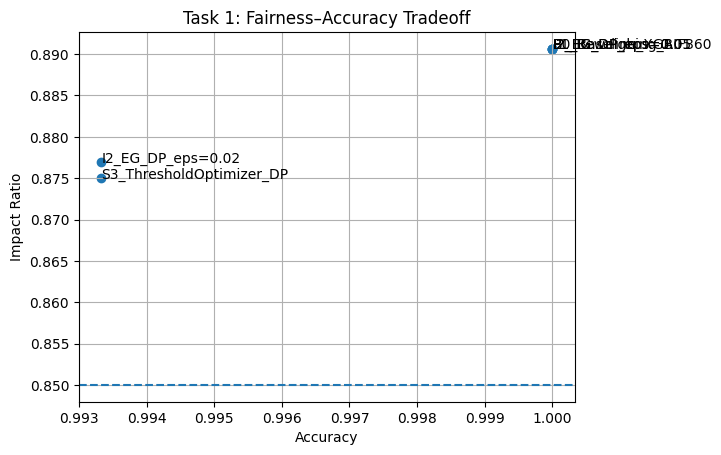

In [46]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(results_df["Accuracy"], results_df["Impact_Ratio"])
for _, r in results_df.iterrows():
    plt.annotate(r["Model"], (r["Accuracy"], r["Impact_Ratio"]))
plt.axhline(0.85, linestyle="--")
plt.xlabel("Accuracy")
plt.ylabel("Impact Ratio")
plt.title("Task 1: Fairness–Accuracy Tradeoff")
plt.grid(True)
plt.show()
